In [6]:
import torch
from llm_from_scratch.c4 import GPTModel, GPTConfig

# 1 We shorten the context length from 1,024 to 256 tokens.
# 2 It’s possible and common to set dropout to 0.
GPT_CONFIG_124M: GPTConfig = {
    "vocab_size": 50257,
    "context_length": 256,  # 1
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,  # 2
    "qkv_bias": False,
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()
None

In [31]:
import tiktoken
from llm_from_scratch.c4 import generate_text_simple
from llm_from_scratch.c5 import text_to_token_ids, token_ids_to_text

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [4]:
inputs = torch.tensor(
    [
        [16833, 3626, 6100],  # ["every effort moves",
        [40, 1107, 588],
    ]
)  #  "I really like"]

targets = torch.tensor(
    [
        [3626, 6100, 345],  # [" effort moves you",
        [1107, 588, 11311],
    ]
)  #  " really like chocolate"]

with torch.no_grad():  # 1
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)  # 2
print(probas.shape)

token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

torch.Size([2, 3, 50257])
Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [5]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4537e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6771e-05, 4.7559e-06])


In [6]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [7]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [8]:
from llm_from_scratch.c2 import VERDICT_PATH

text_data = VERDICT_PATH.read_text()

In [9]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [10]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [11]:
from llm_from_scratch.c2 import create_dataloader_v1

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0,
)

In [12]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [13]:
import math

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


def calc_loss_batch(
    input_batch: torch.Tensor,
    target_batch: torch.Tensor,
    model: nn.Module,
    device: str | torch.device,
):
    input_batch = input_batch.to(device, copy=True)  # 1
    target_batch = target_batch.to(device, copy=True)
    logits = model(input_batch)
    loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(
    data_loader: DataLoader,
    model: nn.Module,
    device: torch.device,
    num_batches: int | None = None,
):
    total_loss = 0.0

    if len(data_loader) == 0:
        return math.nan
    elif num_batches is None:
        num_batches = len(data_loader)  # 1
    else:
        num_batches = min(num_batches, len(data_loader))  # 2

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()  # 3
        else:
            break
    return total_loss / num_batches  # 4

In [14]:
import time


def pick_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")


start = time.time()

device = pick_device()
print("Device chosen is", device)

model.to(device)  # 1
with torch.no_grad():  # 2
    train_loss = calc_loss_loader(train_loader, model, device)  # 3
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

print(f"Time: {time.time()-start:.4f}")

Device chosen is mps
Training loss: 10.987582206726074
Validation loss: 10.981103897094727
Time: 0.7916


In [15]:
def train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter,
    start_context,
    tokenizer,
):
    train_losses, val_losses, track_tokens_seen = [], [], []  # 1
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):  # 2
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 3
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # 4
            optimizer.step()  # 5
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:  # 6
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )

        generate_and_print_sample(  # 7
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # 1
    with torch.no_grad():  # 2
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device, copy=True)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded, max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # 1
    model.train()

In [16]:
torch.manual_seed(123)
# MPS has some issue, investigate later.
device = torch.device("cpu")  # pick_device()
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),  # 1
    lr=0.0004,
    weight_decay=0.1,
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.723, Val loss 6.598
Ep 3 (Step 000025): Train loss 5.204, Val loss 6.351
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.420, Val loss 6.279
Ep 4 (Step 000035): Train loss 4.071, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.733, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

In [17]:
# Using MPS (seems to be broken somehow)
#  See also https://discuss.pytorch.org/t/training-doesnt-converge-when-running-on-m1-pro-gpu-mps-device/157918/12

torch.manual_seed(123)
# MPS has some issue, investigate later.
mps = torch.device("mps")  # pick_device()
model_mps = GPTModel(GPT_CONFIG_124M)
model_mps.to(mps)
optimizer_mps = torch.optim.AdamW(
    model_mps.parameters(),  # 1
    lr=0.0004,
    weight_decay=0.1,
)
num_epochs = 10
train_losses_mps, val_losses_mps, tokens_seen_mps = train_model_simple(
    model_mps,
    train_loader,
    val_loader,
    optimizer_mps,
    mps,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer,
)

Ep 1 (Step 000000): Train loss 10.900, Val loss 10.900
Ep 1 (Step 000005): Train loss 9.940, Val loss 9.987
Every effort moves you were were of were were were were were were were were were were were were were were were were were of were were were were were were were of were were were were of were of were of were were were were were were were of were were of were
Ep 2 (Step 000010): Train loss 8.868, Val loss 9.042
Ep 2 (Step 000015): Train loss 8.014, Val loss 8.251
Every effort moves you it it it it it it it it it of it it it it of it it it it of it it it of it it it it it it it it it of me it it it it it it it it it it it it it it of
Ep 3 (Step 000020): Train loss 6.873, Val loss 7.193
Ep 3 (Step 000025): Train loss 6.276, Val loss 6.758
Every effort moves you of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of of
Ep 4 (Step 000030): Train loss 6.116, Val loss 6.682
Ep 4 (Step 000035): Trai

In [18]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()  # 1
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 2
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

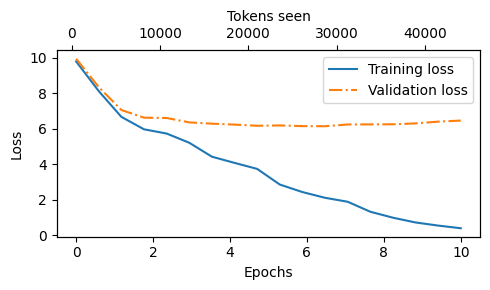

In [19]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [20]:
model.to("cpu")
model.eval()


tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


In [ ]:
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

# This is downloaded with the the `urlretrieve`, so the import needs to stay here.
from gpt_download import download_and_load_gpt2  # noqa: E402

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████████████████████████████████████████| 77.0/77.0 [00:00<00:00, 83.5kiB/s]
encoder.json: 100%|██████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 2.66MiB/s]
hparams.json: 100%|████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 67.5kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████████████████████| 498M/498M [02:29<00:00, 3.33MiB/s]
model.ckpt.index: 100%|██████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 2.06MiB/s]
model.ckpt.meta: 100%|█████████████████████████████████████████| 471k/471k [00:00<00:00, 1.81MiB/s]
vocab.bpe: 100%|███████████████████████████████████████████████| 456k/456k [00:00<00:00, 1.75MiB/s]


In [3]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())
print("Token embedding weight tensor dimensions:", params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
Token embedding weight tensor dimensions: (50257, 768)


In [4]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [10]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})

In [13]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()
None

In [18]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, " "Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [24]:
import numpy as np


def load_weights_into_gpt(gpt, params):  # 1
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):  # 2
        q_w, k_w, v_w = np.split(  # 3
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T
        )

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b
        )
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b
        )

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T,
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"],
        )

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T,
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T,
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"],
        )

        gpt.trf_blocks[b].norm1.weight = assign(
            gpt.trf_blocks[b].norm1.weight, params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].norm1.bias = assign(
            gpt.trf_blocks[b].norm1.bias, params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].norm2.weight = assign(
            gpt.trf_blocks[b].norm2.weight, params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.bias = assign(
            gpt.trf_blocks[b].norm2.bias, params["blocks"][b]["ln_2"]["b"]
        )

    gpt.final_norm.weight = assign(gpt.final_norm.weight, params["g"])
    gpt.final_norm.bias = assign(gpt.final_norm.bias, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])  # 4”

In [32]:
def generate(
    model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None
):
    for _ in range(max_new_tokens):  # 1
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:  # 2
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits
            )
        if temperature > 0.0:  # 3
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:  # 4
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:  # 5
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [39]:
torch.manual_seed(123)

# Both make sense, though different.
device = torch.device("cpu")
# device = torch.device("mps")

load_weights_into_gpt(gpt, params)
gpt.to(device)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5,
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


